In [1]:
from utils import convert_coco_polygons_to_mask, overlay_mask
from PIL import Image
from datasets import load_dataset
from PIL import ImageOps, Image

dataset_id = "jordandavis/fashion_people_detections"
ds = load_dataset(dataset_id, split='train')


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [2]:
def resize_image_pil(image_pil, max_size=1024):
    # Ensure image is in RGB
    if image_pil.mode != "RGB":
        image_pil = image_pil.convert("RGB")

    # Calculate new dimensions preserving aspect ratio
    width, height = image_pil.size
    scale = min(max_size / width, max_size / height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    image_pil = image_pil.resize((new_width, new_height), Image.LANCZOS)

    # Calculate padding needed to reach 1024x1024
    pad_width = (max_size - new_width) // 2
    pad_height = (max_size - new_height) // 2

    # Apply padding symmetrically
    image_pil = ImageOps.expand(
        image_pil,
        border=(
            pad_width,
            pad_height,
            max_size - new_width - pad_width,
            max_size - new_height - pad_height,
        ),
        fill=(0, 0, 0),
    )

    return image_pil

Num Polygons: 7
foot


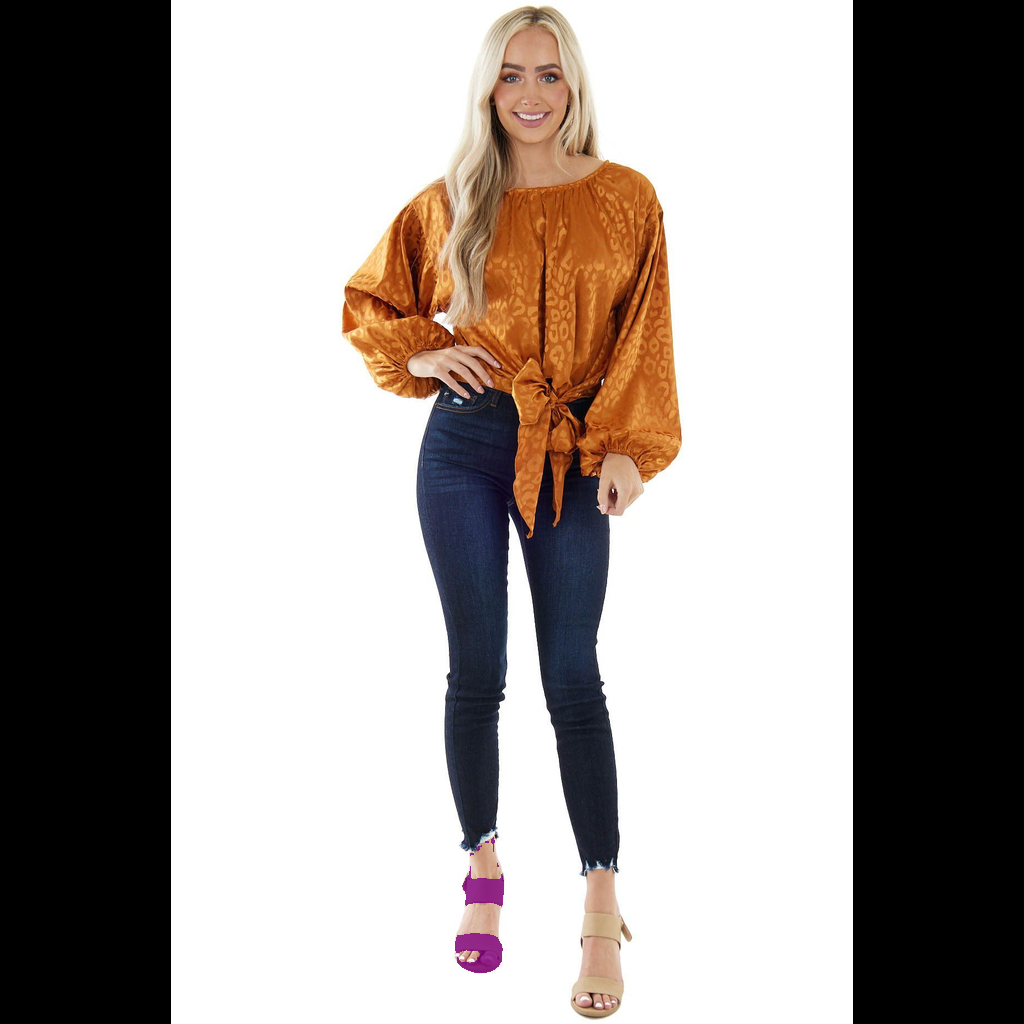

In [4]:
def sanity_check(ds, row=102, mask_row=2):
    image = ds[row]["image"]
    image = resize_image_pil(image)

    polygons = ds[row]["mask_metadata"][mask_row]["polygons"]
    label = ds[row]["mask_metadata"][mask_row]["label"]

    mask = convert_coco_polygons_to_mask(polygons, 1024, 1024)
    mask_image = Image.fromarray(mask)
    overlay = overlay_mask(image, mask_image, opacity=0.8)

    print(label)
    display(overlay)


row = 4998
mask_row = 3

polygons = ds[row]["mask_metadata"][mask_row]["polygons"]
num_polygons = len(polygons)
print(f"Num Polygons: {num_polygons}")
sanity_check(ds, row, mask_row)

In [5]:
def min_index(arr1, arr2):
    """
    Find a pair of indexes with the shortest distance.

    Args:
        arr1: (N, 2).
        arr2: (M, 2).
    Return:
        a pair of indexes(tuple).
    """
    dis = ((arr1[:, None, :] - arr2[None, :, :]) ** 2).sum(-1)
    return np.unravel_index(np.argmin(dis, axis=None), dis.shape)

In [6]:
def merge_multi_segment(segments):
    """
    Merge multi segments to one list. Find the coordinates with min distance between each segment, then connect these
    coordinates with one thin line to merge all segments into one.

    Args:
        segments(List(List)): original segmentations in coco's json file.
            like [segmentation1, segmentation2,...],
            each segmentation is a list of coordinates.
    """
    s = []
    segments = [np.array(i).reshape(-1, 2) for i in segments]
    idx_list = [[] for _ in range(len(segments))]

    # record the indexes with min distance between each segment
    for i in range(1, len(segments)):
        idx1, idx2 = min_index(segments[i - 1], segments[i])
        idx_list[i - 1].append(idx1)
        idx_list[i].append(idx2)

    # use two round to connect all the segments
    for k in range(2):
        # forward connection
        if k == 0:
            for i, idx in enumerate(idx_list):
                # middle segments have two indexes
                # reverse the index of middle segments
                if len(idx) == 2 and idx[0] > idx[1]:
                    idx = idx[::-1]
                    segments[i] = segments[i][::-1, :]

                segments[i] = np.roll(segments[i], -idx[0], axis=0)
                segments[i] = np.concatenate([segments[i], segments[i][:1]])
                # deal with the first segment and the last one
                if i in [0, len(idx_list) - 1]:
                    s.append(segments[i])
                else:
                    idx = [0, idx[1] - idx[0]]
                    s.append(segments[i][idx[0] : idx[1] + 1])

        else:
            for i in range(len(idx_list) - 1, -1, -1):
                if i not in [0, len(idx_list) - 1]:
                    idx = idx_list[i]
                    nidx = abs(idx[1] - idx[0])
                    s.append(segments[i][nidx:])
    return s

In [7]:
polygons = ds[row]["mask_metadata"][mask_row]["polygons"]
cls = ds[row]["mask_metadata"][mask_row]["label_id"]

In [8]:
import numpy as np
from pathlib import Path

In [9]:
h = 1024 
w = 1024

In [11]:
len(polygons)

7

In [10]:
segments = []

if len(polygons) > 1:
    s = merge_multi_segment(polygons)
    s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
else:
    s = [j for i in polygons for j in i]  # all segments concatenated
    s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
s = [cls] + s
if s not in segments:
    segments.append(s)

In [51]:
# use_segments = True
# fn = Path("datasets/fashion_people_detection")
# f = Path("test.jpg")
# bboxes =  [1]


# with open((fn / f).with_suffix(".txt"), "a") as file:
#     for i in range(len(bboxes)):
#         line = (*(segments[i] if use_segments else bboxes[i]),)  # cls, box or segments
#         file.write(("%g " * len(line)).rstrip() % line + "\n")

In [13]:
def get_lines(md, image_width, image_height):
    lines = []
    for row in md:
        label = row.get("label")
        label_id = row.get("label_id")
        coco_polygons = row.get("polygons")

        if len(coco_polygons) > 1:
            yolo_polygons = merge_multi_segment(coco_polygons)
            yolo_polygons = (np.concatenate(yolo_polygons, axis=0) / np.array([image_width, image_height])).reshape(-1).tolist()

        else:
            yolo_polygons = [j for i in coco_polygons for j in i]
            yolo_polygons = (np.array(yolo_polygons).reshape(-1, 2) / np.array([image_width, image_height])).reshape(-1).tolist()


        yolo_polygons_str = " ".join([str(coord) for coord in yolo_polygons])
        yolo_line = f"{label_id} {yolo_polygons_str}"
        lines.append(yolo_line)
    return lines

In [19]:
get_lines(ds[row]["mask_metadata"], 1024, 1024)

['1 0.5400390625 0.177734375 0.5458984375 0.177734375 0.5458984375 0.17578125 0.544921875 0.1748046875 0.54296875 0.1748046875 0.5419921875 0.17578125 0.541015625 0.17578125 0.5400390625 0.1767578125 0.5400390625 0.177734375 0.5185546875 0.1728515625 0.51953125 0.173828125 0.5205078125 0.173828125 0.5185546875 0.17578125 0.5185546875 0.177734375 0.51953125 0.1787109375 0.5224609375 0.1787109375 0.5234375 0.177734375 0.5244140625 0.177734375 0.5283203125 0.173828125 0.529296875 0.173828125 0.53125 0.17578125 0.5322265625 0.17578125 0.533203125 0.1767578125 0.533203125 0.1796875 0.5341796875 0.1806640625 0.513671875 0.1630859375 0.5166015625 0.1630859375 0.5205078125 0.1591796875 0.525390625 0.1591796875 0.52734375 0.1611328125 0.5302734375 0.1611328125 0.5302734375 0.16015625 0.53125 0.1591796875 0.53125 0.1572265625 0.529296875 0.1552734375 0.529296875 0.1513671875 0.529296875 0.150390625 0.5302734375 0.1494140625 0.5302734375 0.1484375 0.5322265625 0.146484375 0.5361328125 0.146484375